In [2]:
from datasets import load_dataset
import numpy as np
from transformers import AutoTokenizer
import evaluate
from datasets import load_dataset, concatenate_datasets
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import json
import pandas as pd

train_data = load_dataset('artem9k/ai-text-detection-pile')
train_data["train"] = train_data["train"].shuffle().select(range(200000))
# print(train_data)
# print(train_data['train'][0])
# get validation data from the jsonl files in this directory
arxiv_chatGPT = load_dataset('json', data_files='arxiv_chatGPT.jsonl')
arxiv_cohere = load_dataset('json', data_files='arxiv_cohere.jsonl')
reddit_chatGPT = load_dataset('json', data_files='reddit_chatGPT.jsonl')
reddit_cohere = load_dataset('json', data_files='reddit_cohere.jsonl')
german_wikipedia = load_dataset('json', data_files='german_wikipedia.jsonl')
hewlett = load_dataset('json', data_files='hewlett.json')
toefl = load_dataset('json', data_files='toefl.json')
# print(arxiv_chatGPT)
# print(arxiv_cohere)
# print(reddit_chatGPT)
# print(reddit_cohere)

# only keep "human_text" and "machine_text" features and get rid of the rest
arxiv_chatGPT_human = arxiv_chatGPT.map(lambda x: {'text': x['human_text'], 'source': 'human'}).select_columns(['text', 'source'])
arxiv_cohere_human = arxiv_cohere.map(lambda x: {'text': x['human_text'], 'source': 'human'}).select_columns(['text', 'source'])
reddit_chatGPT_human = reddit_chatGPT.map(lambda x: {'text': x['human_text'], 'source': 'human'}).select_columns(['text', 'source'])
reddit_cohere_human = reddit_cohere.map(lambda x: {'text': x['human_text'], 'source': 'human'}).select_columns(['text', 'source'])
arxiv_chatGPT_machine = arxiv_chatGPT.map(lambda x: {'text': x['machine_text'], 'source': 'ai'}).select_columns(['text', 'source'])
arxiv_cohere_machine = arxiv_cohere.map(lambda x: {'text': x['machine_text'], 'source': 'ai'}).select_columns(['text', 'source'])
reddit_chatGPT_machine = reddit_chatGPT.map(lambda x: {'text': x['machine_text'], 'source': 'ai'}).select_columns(['text', 'source'])
reddit_cohere_machine = reddit_cohere.map(lambda x: {'text': x['machine_text'], 'source': 'ai'}).select_columns(['text', 'source'])
german_wikipedia_human = german_wikipedia.map(lambda x: {'text': x['human_text'], 'source': 'human'}).select_columns(['text', 'source'])
german_wikipedia_machine = german_wikipedia.map(lambda x: {'text': x['machine_text'], 'source': 'ai'}).select_columns(['text', 'source'])
hewlett = hewlett.map(lambda x: {'text': x['document'], 'source': 'human'}).select_columns(['text', 'source'])
toefl = toefl.map(lambda x: {'text': x['document'], 'source': 'human'}).select_columns(['text', 'source'])

arxiv_chatGPT = concatenate_datasets([arxiv_chatGPT_human['train'], arxiv_chatGPT_machine['train']])
arxiv_chatGPT.shuffle()
arxiv_cohere = concatenate_datasets([arxiv_cohere_human['train'], arxiv_cohere_machine['train']])
arxiv_cohere.shuffle()
reddit_chatGPT = concatenate_datasets([reddit_chatGPT_human['train'], reddit_chatGPT_machine['train']])
reddit_chatGPT.shuffle()
reddit_cohere = concatenate_datasets([reddit_cohere_human['train'], reddit_cohere_machine['train']])
reddit_cohere.shuffle()
german_wikipedia = concatenate_datasets([german_wikipedia_human['train'], german_wikipedia_machine['train']])
german_wikipedia.shuffle()
hewlett.shuffle()
toefl.shuffle()

# concatenate the datasets
val_data = concatenate_datasets([arxiv_chatGPT_human['train'], arxiv_cohere_human['train'], reddit_chatGPT_human['train'], reddit_cohere_human['train'],
                                     arxiv_chatGPT_machine['train'], arxiv_cohere_machine['train'], reddit_chatGPT_machine['train'], reddit_cohere_machine['train']])
# shuffle the dataset
val_data = val_data.shuffle(seed=42)
print(val_data)

Map: 100%|██████████| 91/91 [00:00<00:00, 14064.47 examples/s]

Dataset({
    features: ['text', 'source'],
    num_rows: 24000
})


In [3]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel

class DesklibAIDetectionModel(PreTrainedModel):
    config_class = AutoConfig

    def __init__(self, config):
        super().__init__(config)
        # Initialize the base transformer model.
        self.model = AutoModel.from_config(config)
        # Define a classifier head.
        self.classifier = nn.Linear(config.hidden_size, 1)
        # Initialize weights (handled by PreTrainedModel)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Forward pass through the transformer
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask

        # Classifier
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1), labels.float())

        output = {"logits": logits}
        if loss is not None:
            output["loss"] = loss
        return output

def predict_single_text_idk(text, model, tokenizer, device, max_len=512, threshold=0.5):
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        print(logits)
        probability = torch.sigmoid(logits).item()

    label = 1 if probability >= threshold else 0
    return probability, label



In [42]:
model_directory = "desklib/ai-text-detector-v1.01"

# --- Load tokenizer and model ---
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = DesklibAIDetectionModel.from_pretrained(model_directory)

# --- Set up device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Example Input text ---
text_ai = "AI detection refers to the process of identifying whether a given piece of content, such as text, images, or audio, has been generated by artificial intelligence. This is achieved using various machine learning techniques, including perplexity analysis, entropy measurements, linguistic pattern recognition, and neural network classifiers trained on human and AI-generated data. Advanced AI detection tools assess writing style, coherence, and statistical properties to determine the likelihood of AI involvement. These tools are widely used in academia, journalism, and content moderation to ensure originality, prevent misinformation, and maintain ethical standards. As AI-generated content becomes increasingly sophisticated, AI detection methods continue to evolve, integrating deep learning models and ensemble techniques for improved accuracy."
text_human = "It is estimated that a major part of the content in the internet will be generated by AI / LLMs by 2025. This leads to a lot of misinformation and credibility related issues. That is why if is important to have accurate tools to identify if a content is AI generated or human written"

# --- Run prediction ---
probability, predicted_label = predict_single_text_idk(text_ai, model, tokenizer, device)
print(f"Probability of being AI generated: {probability:.4f}")
print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")

probability, predicted_label = predict_single_text_idk(text_human, model, tokenizer, device)
print(f"Probability of being AI generated: {probability:.4f}")
print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")

tensor([[5.9590]], device='cuda:0')
Probability of being AI generated: 0.9974
Predicted label: AI Generated
tensor([[-0.3042]], device='cuda:0')
Probability of being AI generated: 0.4245
Predicted label: Not AI Generated


In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [5]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['text'],
        # padding='max_length',
        truncation=True,
        # max_length=1024,
        # return_tensors='pt'
    )
    model_inputs["labels"] = [0 if s == 'human' else 1 for s in examples['source']]
    
    return model_inputs

In [ ]:
# 10-15 min
# TODO: please only run this if you don't already have the tokenized data in your local file system
tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_val_data = val_data.map(preprocess_function, batched=True)

Map: 100%|██████████| 24000/24000 [00:24<00:00, 995.38 examples/s] 


In [ ]:
# Save the tokenized data
# no need to run if you already have the tokenized datasets in the current directory
tokenized_train_data.save_to_disk("./tokenized_train_data")
tokenized_val_data.save_to_disk("./tokenized_val_data")

NameError: name 'tokenized_train_data' is not defined

In [ ]:
from datasets import load_from_disk
# TODO: only load the tokenized data if you saved it to disk earlier
tokenized_train_data_loaded = load_from_disk("./tokenized_train_data")
tokenized_val_data_loaded = load_from_disk("./tokenized_val_data")

In [7]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
import evaluate

accuracy = evaluate.load("accuracy")

In [9]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
id2label = {0: "Not AI Generated", 1: "AI Generated"}
label2id = {"Not AI Generated": 0, "AI Generated": 1}

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
# )
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
# model = DesklibAIDetectionModel.from_pretrained("distilbert/distilbert-base-uncased")
# --- Set up device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [ ]:
from transformers import EarlyStoppingCallback
training_args = TrainingArguments(
    output_dir="ai_detection_model",
    eval_strategy="steps",
    logging_steps=50,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # num_train_epochs=2,
    weight_decay=0.01,
    # eval_strategy="epoch",
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data_loaded["train"],
    eval_dataset=tokenized_val_data_loaded,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback()],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.484600,0.662013,0.504750
100,0.316300,0.466224,0.758417
150,0.212600,0.359433,0.812375
200,0.191600,0.338633,0.813958
250,0.170200,0.400585,0.767542


TrainOutput(global_step=250, training_loss=0.27505376052856445, metrics={'train_runtime': 2249.0587, 'train_samples_per_second': 266.778, 'train_steps_per_second': 8.337, 'total_flos': 1059739189248000.0, 'train_loss': 0.27505376052856445, 'epoch': 0.04})

In [31]:
# plot loss as a graph
import pandas as pd
import matplotlib.pyplot as plt
history = pd.DataFrame(trainer.state.log_history)



In [32]:
history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4846,2.972165,0.00001,0.008,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.008,50,0.662013,0.504750,373.5790,64.243,2.008,NaN,NaN,NaN,NaN,NaN
2,0.3163,4.764493,0.00001,0.016,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.016,100,0.466224,0.758417,373.3280,64.287,2.009,NaN,NaN,NaN,NaN,NaN
4,0.2126,1.702819,0.00001,0.024,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.024,150,0.359433,0.812375,373.1718,64.314,2.010,NaN,NaN,NaN,NaN,NaN
6,0.1916,4.804159,0.00001,0.032,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.032,200,0.338633,0.813958,373.5840,64.243,2.008,NaN,NaN,NaN,NaN,NaN
8,0.1702,6.649611,0.00001,0.040,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.040,250,0.400585,0.767542,373.0792,64.329,2.010,NaN,NaN,NaN,NaN,NaN


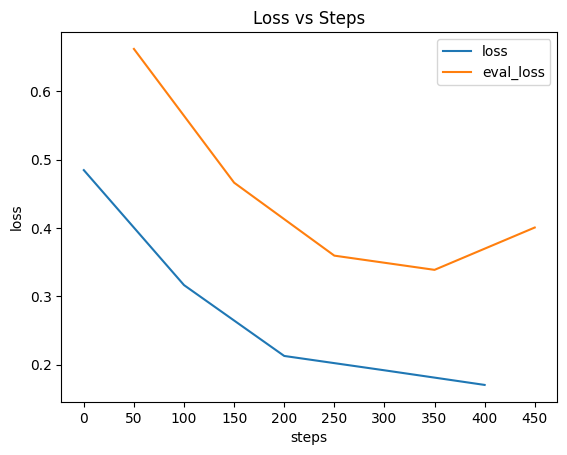

In [35]:
# plot the loss
# filter out nan
history2 = history.dropna(subset=['loss'])
history3 = history.dropna(subset=['eval_loss'])


plt.plot(history2['loss'], label='loss')
plt.plot(history3['eval_loss'], label='eval_loss')
x = [i for i in range(0, 10)]
plt.xticks([i for i in x], [i * 50 for i in x])  # relabel ticks
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Loss vs Steps')
plt.legend()
plt.show()

In [ ]:
# TODO: please uncomment the following line to save the model to local file system
# trainer.save_model("ai_detection_model_v2")

In [ ]:
# initialize model
import torch
def predict_single_text(text, model, tokenizer, device, max_len=512, threshold=0.5):
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        # softmax the logits
        logits = torch.softmax(logits, dim=1)
        # get probability of being AI generated
        probability = logits[0][1].item()

    label = 1 if probability >= threshold else 0
    return probability, label
# --- Example Input text ---
text_ai = "AI detection refers to the process of identifying whether a given piece of content, such as text, images, or audio, has been generated by artificial intelligence. This is achieved using various machine learning techniques, including perplexity analysis, entropy measurements, linguistic pattern recognition, and neural network classifiers trained on human and AI-generated data. Advanced AI detection tools assess writing style, coherence, and statistical properties to determine the likelihood of AI involvement. These tools are widely used in academia, journalism, and content moderation to ensure originality, prevent misinformation, and maintain ethical standards. As AI-generated content becomes increasingly sophisticated, AI detection methods continue to evolve, integrating deep learning models and ensemble techniques for improved accuracy."
text_human = "It is estimated that a major part of the content in the internet will be generated by AI / LLMs by 2025. This leads to a lot of misinformation and credibility related issues. That is why if is important to have accurate tools to identify if a content is AI generated or human written"
# print(arxiv_chatGPT['train'][0])
# text_ai = arxiv_chatGPT['train'][1]['machine_text']
# text_human = arxiv_chatGPT['train'][1]['human_text']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Run prediction ---


# TODO: Please change the name of the model to the one that you saved earlier
tokenizer = AutoTokenizer.from_pretrained("ai_detection_model_final")
tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "ai_detection_model_final", num_labels=2, id2label=id2label, label2id=label2id
)
tuned_model.to(device)

untuned_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
untuned_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
untuned_model.to(device)



# loop through val data and verify 


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# dev set evaluation
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in val_data:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

Accuracy: 0.8237
Recall: 0.7701
Precision: 0.8626
F1: 0.8137


AUC-ROC: 0.9442


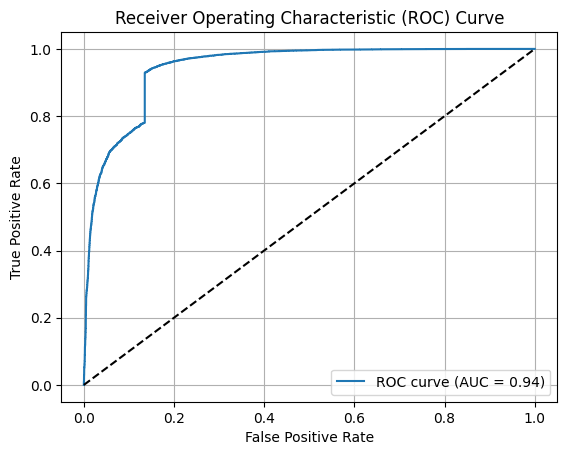

In [ ]:
# AUC calculations
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

# Print AUC score
print(f"AUC-ROC: {auc_score:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# evlauation using the untuned distilbert
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in val_data:
    text = example['text']
    probability, predicted_label = predict_single_text(text, untuned_model, untuned_tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

Accuracy: 0.5128
Recall: 0.9200
Precision: 0.5071
F1: 0.6538


In [ ]:
# evaluation with untuned roberta
untuned_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")
untuned_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilroberta-base", num_labels=2, id2label=id2label, label2id=label2id
)
untuned_model.to(device)
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in val_data:
    text = example['text']
    probability, predicted_label = predict_single_text(text, untuned_model, untuned_tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.5000
Recall: 1.0000
Precision: 0.5000
F1: 0.6667


In [ ]:
# fine-tuned model evaluation on arxiv_chatGPT dataset
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in arxiv_chatGPT:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"Arxiv chatGPT Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

Arxiv chatGPT Accuracy: 0.9092
Recall: 0.9137
Precision: 0.9055
F1: 0.9096


In [ ]:
# fine-tuned model evaluation on arxiv cohere dataset

correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in arxiv_cohere:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"Arxiv cohere Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

Arxiv cohere Accuracy: 0.8753
Recall: 0.8460
Precision: 0.8987
F1: 0.8716


In [ ]:
# evaluation on reddit chatGPT dataset
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in reddit_chatGPT:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"reddit chatGPT Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

reddit chatGPT Accuracy: 0.8982
Recall: 0.9463
Precision: 0.8632
F1: 0.9028


In [ ]:
# evaluation on reddit cohere dataset
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in reddit_cohere:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"reddit cohere Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

reddit cohere Accuracy: 0.6122
Recall: 0.3743
Precision: 0.7139
F1: 0.4911


In [ ]:
# Ethical data german wikipedia evaluation
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in german_wikipedia:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"german wikipedia Accuracy: {correct/total:.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

german wikipedia Accuracy: 0.6190
Recall: 0.3720
Precision: 0.7352
F1: 0.4940


In [ ]:
# Ethical data hewlett evaluation
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in hewlett['train']:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"hewlett Accuracy: {correct/total:.4f}")
# if(tp + fn) == 0:
#     print("Recall: N/A (no positive samples)")
# else:
#     print(f"Recall: {tp/(tp+fn):.4f}")
# print(f"Precision: {tp/(tp+fp):.4f}")
# print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

hewlett Accuracy: 0.9886


In [ ]:
# Ethical data toefl evaluation
correct = 0
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
y_true = []
y_scores = []
for example in toefl['train']:
    text = example['text']
    probability, predicted_label = predict_single_text(text, tuned_model, tokenizer, device)
    # print(f"Probability of being AI generated: {probability:.4f}")
    # print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")
    
    y_scores.append(probability)       
    if(predicted_label == 1 and example['source'] == 'ai') or (predicted_label == 0 and example['source'] == 'human'):
        correct += 1
    total += 1

    # get tp/fp/fn/tn
    if predicted_label == 1 and example['source'] == 'ai':
        tp += 1
        y_true.append(1)
    elif predicted_label == 1 and example['source'] == 'human':
        fp += 1
        y_true.append(0)
    elif predicted_label == 0 and example['source'] == 'ai':
        fn += 1
        y_true.append(1)
    elif predicted_label == 0 and example['source'] == 'human':
        tn += 1
        y_true.append(0)


print(f"toefl Accuracy: {correct/total:.4f}")
# print(f"Recall: {tp/(tp+fn):.4f}")
# print(f"Precision: {tp/(tp+fp):.4f}")
# print(f"F1: {2*tp/(2*tp+fp+fn):.4f}")

toefl Accuracy: 0.1429
